# LAB 5 : Convolutional Neural Networks  

Name : Joshitha Gandra, Vaishnavi

Roll Number : 180020009, 180020039

Referrence Material : 

  MNIST Digit Dataset : http://yann.lecun.com/exdb/mnist/

  CNN : https://towardsdatascience.com/a-guide-to-convolutional-neural-networks-from-scratch-f1e3bfc3e2de

#**Problem 1** : Demonstrate the working principle of convolution neural network (CNN)

Observation to be demonstrated:
1. Use suitable data to demonstrate the same (MNIST digit data can be used).
2. Demonstrate the translation invariant property of pooling layer (can choose two
image, from which one is translated and show the output of pooling layer is near
to identical for both the images ).
3. Demonstrate how backpropagation works with max pooling layer.

the same.

**Note: Take only two class and a small network, and write you own code to demonstrate the same.**

##Write down the Objectives, Hypothesis and Experimental description for the above problem


Objective : Demostrate the working of CNN, translation invariant property of pooling layer and the backpropagation with it.

Hypothesis : The CNN layers should learn the patterns of image and classify it. The pooling layer should make the image robust to translation invariant.

Experimental Description : Load the mnist data

1. take 2 classes
2. Convolution --> Max pooling --> FC with sigmoid
3. Used BCELoss

###**Motivation**

####A classic use case of CNNs is to perform image classification. 
####It’s a seemingly simple task - why not just use a normal Neural Network?



*   **Reason 1 :** Images used for Computer Vision problems nowadays are often 224x224 or larger. Imagine building a neural network to process 224x224 color images: including the 3 color channels (RGB) in the image, that comes out to 224 x 224 x 3 = 150,528 input features! A typical hidden layer in such a network might have 1024 nodes, so we’d have to train 150,528 x 1024 = 150+ million weights for the first layer alone. Our network would be huge and nearly impossible to train.
*   **Reason 2 :** If you trained a network to detect a face, you’d want it to be able to a detect the face regardless of where it appears in the image. Imagine training a network that works well on a specific face image, but then feeding it a slightly shifted version of the same image. It would not activate the same neurons, so the network would react completely differently.




 The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. 

## CNN

CNNs are basically just neural networks that use Convolutional layers, which are based on the mathematical operation of convolution. Conv layers consist of a set of filters, which we can think of as just 2d matrices of numbers. 


<img src='https://miro.medium.com/max/1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif' width="750" align="center">

The Conv class takes only one argument: the number of filters. 

We initialize a random filters using NumPy’s randn() method.

iterate_regions() yields all valid 3x3 image regions.
This will be useful for implementing the backwards portion of later on

In [ ]:
import numpy as np

'''
Note: In this implementation, we assume the input is a 2d numpy array for simplicity, because that's
how our MNIST images are stored. This works for us because we use it as the first layer in our
network, but most CNNs have many more Conv layers. If we were building a bigger network that needed
to use Conv multiple times, we'd have to make the input be a 3d numpy array.
'''

class Conv:
  # A Convolution layer using 3x3 filters.

  def __init__(self, num_filters):
    self.num_filters = num_filters

    # filters is a 3d array with dimensions (num_filters, 3, 3)
    # We divide by 10 to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 10

  def iterate_regions(self, image):
    '''
    Generates all possible 3x3 image regions using valid padding.
    - image is a 2d numpy array.
    '''
    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    # We aren't returning anything here since we use Conv as the first layer in our CNN.
    # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
    # other layer in our CNN.
    return None

We are basically trying to learn the values of filter(s) using backprop

Neighboring pixels in images tend to have similar values, so conv layers will typically also produce similar values for neighboring pixels in outputs. As a result, much of the information contained in a conv layer’s output is redundant.

Pooling layers solve this problem. All they do is reduce the size of the input it’s given by (you guessed it) pooling values together in the input. 



<img src='https://victorzhou.com/ac441205fd06dc037b3db2dbf05660f7/pool.gif' width="750" align="center">

In [ ]:
class MaxPool:
  # A Max Pooling layer using a pool size of 2.

  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 2d numpy array
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

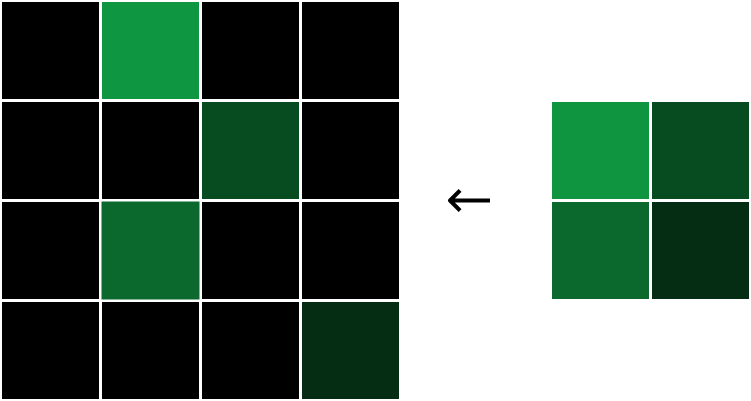

In [ ]:

class Sigmoid:
  # A standard fully-connected layer with sigmoid activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    '''
    Performs a forward pass of the sigmoid layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals
    # print('totals ', totals)
    # print('exp ',np.exp(-1*totals))

    return 1.0 / (1.0 + np.exp(-1*totals))

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the sigmoid layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      out = 1.0 / (1.0 + np.exp(-1*self.last_totals))
      d_out_d_t = (1.0 - out) * out


      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

Data

In [ ]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('X_train: ' + str(train_images.shape))
print('Y_train: ' + str(train_labels.shape))
print('X_test:  '  + str(test_images.shape))
print('Y_test:  '  + str(test_labels.shape))

11501568/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
import numpy as np

train_filter = np.where((train_labels == 0 ) | (train_labels == 1))
test_filter = np.where((test_labels == 0) | (test_labels == 1))

In [ ]:
train_images, train_labels = train_images[train_filter], train_labels[train_filter]
test_images, test_labels = test_images[test_filter], test_labels[test_filter]

In [ ]:
print('X_train: ' + str(train_images.shape))
print('Y_train: ' + str(train_labels.shape))
print('X_test:  '  + str(test_images.shape))
print('Y_test:  '  + str(test_labels.shape))

X_train: (12665, 28, 28)
Y_train: (12665,)
X_test:  (2115, 28, 28)
Y_test:  (2115,)


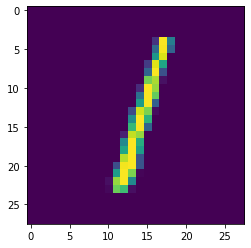

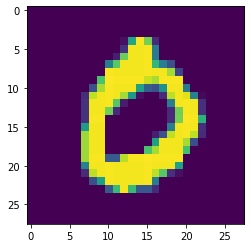

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(test_images[0])
plt.show()

plt.imshow(test_images[1])
plt.show()

## Neural Network for MNIST data

A neural network would actually work just fine fon MNIST data. We could treat each image as a 28 x 28 = 784-dimensional vector, feed that to a 784-dim input layer, stack a few hidden layers, and finish with an output layer of 10 nodes, 1 for each digit.

In our class, where we have 2 classes, a 784-dim input layer with an output layer of 1 node with sigmoid activation would work.

This would only work because the MNIST dataset contains small images that are centered, so we wouldn’t run into the issues of size or shifting.

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Sequential

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 785       
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

In [ ]:
model.fit(train_images, train_labels, epochs=3, 
          validation_data=(test_images, test_labels))

Epoch 1/3
396/396 [==============================] - 2s 3ms/step - loss: 0.7098 - acc: 0.9827 - val_loss: 0.0503 - val_acc: 0.9967
Epoch 2/3
396/396 [==============================] - 1s 2ms/step - loss: 0.1072 - acc: 0.9971 - val_loss: 0.0416 - val_acc: 0.9976
Epoch 3/3
396/396 [==============================] - 1s 2ms/step - loss: 0.0446 - acc: 0.9984 - val_loss: 0.0500 - val_acc: 0.9976


## Convolution with Sigmoid : Con layer (8 filters) --> Max pool (2x2) --> FC with sigmoid

For our MNIST CNN, we’ll use a small conv layer with 8 filters as the initial layer in our network. This means it’ll turn the 28x28 input image into a 26x26x8 output

((shape of width of filter x shape of height filter  x number of filters in the previous layer+1) x number of filters)

(3 × 3 (filter size) + 1) × 8 (number of filters) =  80.


parameters in fully connected sigmoid : (13x13x8 = 1352)x1 + 1x1 = 1353

Total = 1353 + 80 = 1433

Pooling divides the input’s width and height by the pool size. For our MNIST CNN, we’ll place a Max Pooling layer with a pool size of 2 right after our initial conv layer. The pooling layer will transform a 26x26x8 input into a 13x13x8 output

In [ ]:
conv = Conv(8)                  # 28x28x1 -> 26x26x8
pool = MaxPool()                  # 26x26x8 -> 13x13x8
sigmoid = Sigmoid(13 * 13 * 8, 1) # 13x13x8 -> 1

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. 
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = sigmoid.forward(out)
  # print('out ',out)

  # Calculate binary-cross-entropy loss and accuracy. np.log() is the natural log.
  if (label == 0):
    loss = -np.log(1-out)
    acc = 1 if (out<0.5) else 0
  else:
    loss = -np.log(out)
    acc = 1 if (out>0.5) else 0
  # print('acc ', acc)

  return out, loss, acc

def train(im, label, lr=.0001):
  '''
  Completes a full training step on the given image and label.
  Returns the binary-cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(2)
  if (label==0): 
    gradient[0] = 1 / (1-out)
  else:
    gradient[1] = -1/out

  # Backprop
  gradient = sigmoid.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

print('MNIST CNN initialized!')

# Train the CNN for 2 epochs
for epoch in range(1):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 500 == 0 and i>0:
      print(
        '[Step %d] Past 500 steps: Average Loss %.3f | Accuracy: %.3f' %
        (i + 1, loss / 500, num_correct/500)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

MNIST CNN initialized!
--- Epoch 1 ---
[Step 501] Past 500 steps: Average Loss 0.680 | Accuracy: 0.634
[Step 1001] Past 500 steps: Average Loss 0.654 | Accuracy: 0.662
[Step 1501] Past 500 steps: Average Loss 0.629 | Accuracy: 0.694
[Step 2001] Past 500 steps: Average Loss 0.594 | Accuracy: 0.760
[Step 2501] Past 500 steps: Average Loss 0.553 | Accuracy: 0.828
[Step 3001] Past 500 steps: Average Loss 0.510 | Accuracy: 0.894
[Step 3501] Past 500 steps: Average Loss 0.459 | Accuracy: 0.950
[Step 4001] Past 500 steps: Average Loss 0.397 | Accuracy: 0.970
[Step 4501] Past 500 steps: Average Loss 0.342 | Accuracy: 0.970
[Step 5001] Past 500 steps: Average Loss 0.290 | Accuracy: 0.978
[Step 5501] Past 500 steps: Average Loss 0.258 | Accuracy: 0.980
[Step 6001] Past 500 steps: Average Loss 0.211 | Accuracy: 0.986
[Step 6501] Past 500 steps: Average Loss 0.181 | Accuracy: 0.992
[Step 7001] Past 500 steps: Average Loss 0.153 | Accuracy: 0.994
[Step 7501] Past 500 steps: Average Loss 0.138 | Acc

((shape of width of filter x shape of height filter x number of filters in the previous layer+1) x number of filters)

(3 × 3 (filter size) + 1) × 8 (number of filters) = 80.

parameters in fully connected sigmoid : (6x6x8 = 288)x1 + 1x1 = 289

Total = 289 + 80 = 369

In [ ]:
conv = Conv(8)                  # 28x28x1 -> 26x26x8
pool1 = MaxPool()                  # 26x26x8 -> 13x13x8
pool2 = MaxPool()                  # 13x13x8 -> 6, 6, 8

sigmoid = Sigmoid(6 * 6 * 8, 1) # 6, 6, 8 -> 1

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. 
  out = conv.forward((image / 255) - 0.5)
  out = pool1.forward(out)
  out = pool2.forward(out)
  out = sigmoid.forward(out)
  # print('out ',out)

  # Calculate binary-cross-entropy loss and accuracy. np.log() is the natural log.
  if (label == 0):
    loss = -np.log(1-out)
    acc = 1 if (out<0.5) else 0
  else:
    loss = -np.log(out)
    acc = 1 if (out>0.5) else 0
  # print('acc ', acc)

  return out, loss, acc

def train(im, label, lr=.0001):
  '''
  Completes a full training step on the given image and label.
  Returns the binary-cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(2)
  if (label==0): 
    gradient[0] = 1 / (1-out)
  else:
    gradient[1] = -1/out

  # Backprop
  gradient = sigmoid.backprop(gradient, lr)
  gradient = pool2.backprop(gradient)
  gradient = pool1.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

print('MNIST CNN initialized!')

# Train the CNN for 2 epochs
for epoch in range(1):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 500 == 0 and i>0:
      print(
        '[Step %d] Past 500 steps: Average Loss %.3f | Accuracy: %.3f' %
        (i + 1, loss / 500, num_correct/500)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

MNIST CNN initialized!
--- Epoch 1 ---
[Step 501] Past 500 steps: Average Loss 0.681 | Accuracy: 0.842
[Step 1001] Past 500 steps: Average Loss 0.655 | Accuracy: 0.902
[Step 1501] Past 500 steps: Average Loss 0.627 | Accuracy: 0.876
[Step 2001] Past 500 steps: Average Loss 0.588 | Accuracy: 0.934
[Step 2501] Past 500 steps: Average Loss 0.527 | Accuracy: 0.942
[Step 3001] Past 500 steps: Average Loss 0.478 | Accuracy: 0.952
[Step 3501] Past 500 steps: Average Loss 0.411 | Accuracy: 0.962
[Step 4001] Past 500 steps: Average Loss 0.350 | Accuracy: 0.968
[Step 4501] Past 500 steps: Average Loss 0.297 | Accuracy: 0.960
[Step 5001] Past 500 steps: Average Loss 0.244 | Accuracy: 0.974
[Step 5501] Past 500 steps: Average Loss 0.209 | Accuracy: 0.964
[Step 6001] Past 500 steps: Average Loss 0.183 | Accuracy: 0.964
[Step 6501] Past 500 steps: Average Loss 0.165 | Accuracy: 0.978
[Step 7001] Past 500 steps: Average Loss 0.140 | Accuracy: 0.982
[Step 7501] Past 500 steps: Average Loss 0.143 | Acc

## Translation invariant property of pooling layer

Pooling helps to make the representation become approximately invariant to small translations of the input. Invariance to translation means that if we translate the input by a small amount, the values of most of the pooled outputs do not change.

In [ ]:
# define input data
image1 = [[0, 0, 0, 0, 1, 0],
		      [0, 0, 0, 0, 0, 0],
		      [0, 0, 0, 0, 1, 0],
		      [0, 0, 0, 0, 0, 0],
		      [0, 0, 0, 0, 1, 0],
	      	[0, 0, 0, 0, 0, 0]]

image1 = np.asarray(image1)

image2 = [[0, 0, 0, 0, 0, 0],
		      [0, 0, 0, 0, 1, 0],
		      [0, 0, 0, 0, 0, 0],
		      [0, 0, 0, 0, 1, 0],
		      [0, 0, 0, 0, 0, 0],
	      	[0, 0, 0, 0, 1, 0]]

image2 = np.asarray(image2)

In [ ]:
conv = Conv(1)                  
pool = MaxPool()                  

out1 = conv.forward(image1)
print('conv ',out1.shape)
out_conv = out1.reshape(4,4)
print(out_conv)

conv  (4, 4, 1)
[[ 0.          0.          0.04984722 -0.01095402]
 [ 0.          0.         -0.10442503 -0.01705697]
 [ 0.          0.          0.04984722 -0.01095402]
 [ 0.          0.         -0.10442503 -0.01705697]]


In [ ]:
out2 = conv.forward(image2)
print('conv ',out2.shape)
out_conv = out2.reshape(4,4)
print(out_conv)

conv  (4, 4, 1)
[[ 0.          0.         -0.10442503 -0.01705697]
 [ 0.          0.          0.04984722 -0.01095402]
 [ 0.          0.         -0.10442503 -0.01705697]
 [ 0.          0.          0.04984722 -0.01095402]]


In [ ]:
out1 = pool.forward(out1)
print('maxpooling ',out1.shape)
out_pool = out1.reshape(2,2)
print(out_pool)

maxpooling  (2, 2, 1)
[[0.         0.04984722]
 [0.         0.04984722]]


In [ ]:
out2 = pool.forward(out2)
print('maxpooling ',out2.shape)
out_pool = out2.reshape(2,2)
print(out_pool)

maxpooling  (2, 2, 1)
[[0.         0.04984722]
 [0.         0.04984722]]


## Backpropgation through Max Pooling Layer

Back Propagation in Maxpol:

A Max Pooling layer can’t be trained because it doesn’t actually have any weights, but we still need to implement a backprop() method for it to calculate gradients. We’ll start by adding forward phase caching again. All we need to cache this time is the input:

During the forward pass, the Max Pooling layer takes an input volume and halves its width and height dimensions by picking the max values over 2x2 blocks. The backward pass does the opposite: we’ll double the width and height of the loss gradient by assigning each gradient value to where the original max value was in its corresponding 2x2 block.

For each region max_value was found. Then, for each region, the d_l_d_out was assigned the matrix such that the max value is put up at the aprropiate region and rest of the elements are zero. 

In [ ]:
image = [[0, 0, 0, 0, 0, 0],
		      [0, 0, 0, 0, 1, 0],
		      [0, 0, 0, 0, 0, 0],
		      [0, 0, 1, 0, 1, 0],
		      [0, 0, 0, 0, 0, 0],
	      	[0, 0, 1, 0, 1, 0]]
		      

image = np.asarray(image) 
conv = Conv(1)      #6x6 -->4x4x1         
pool = MaxPool()    # 4x4x1 --> 2x2x1
sigmoid = Sigmoid(2 * 2 * 1, 1)

out1 = conv.forward(image)
print("Forward phase of COnvolution : ")
#print(out1)
for r in out1:
   for c in r:
      print(c,end = " ")
   print()
print()
out2 = pool.forward(out1)
print("Forward Phase of Max Pool : ")
#print(out2)
for r in out2:
   for c in r:
      print(c,end = " ")
   print()
print()

out3 = sigmoid.forward(out2)
print("Sigmoid : ")
print(out3)

# Calculate initial gradient
label = 1
gradient = np.zeros(2)
if (label==0): 
  gradient[0] = 1 / (1-out3)
else:
  gradient[1] = -1/out3

# Backprop
lr = 0.05
gradient = sigmoid.backprop(gradient, lr)
gradient_2 = pool.backprop(gradient)
gradient_3 = conv.backprop(gradient_2, lr)
print("Backward pass of sigmoid : ")

for r in gradient:
   for c in r:
      print(c,end = " ")
   print()
print()

print("Backward pass of Max pool : ")

for r in gradient_2:
   for c in r:
      print(c,end = " ")
   print()
print()


Forward phase of COnvolution : 
[0.] [0.] [0.06423184] [0.17547238] 
[-0.14913973] [-0.04510555] [0.00500459] [-0.1187315] 
[0.06423184] [0.17547238] [0.2301105] [0.17547238] 
[0.08836351] [-0.1187315] [-0.06455391] [-0.1187315] 

Forward Phase of Max Pool : 
[0.] [0.17547238] 
[0.17547238] [0.2301105] 

Sigmoid : 
[0.51832913]
Backward pass of sigmoid : 
[-0.12774748] [0.01670388] 
[-0.08040175] [-0.10496281] 

Backward pass of Max pool : 
[-0.12774748] [-0.12774748] [0.] [0.01670388] 
[0.] [0.] [0.] [0.] 
[0.] [-0.08040175] [-0.10496281] [0.] 
[0.] [0.] [0.] [0.] 



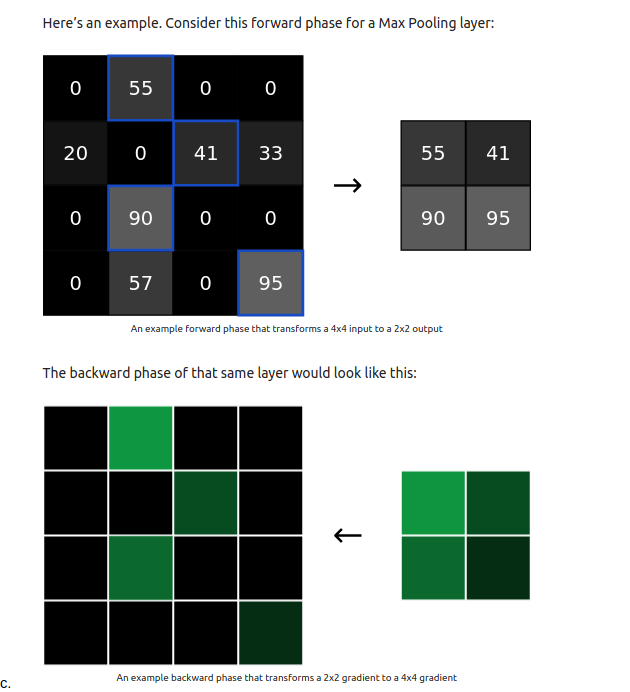

## Inferences and Conclusion : State all the key observations and conclusion

1. In CNN, : 
Conv layers convolve filters with images to produce more useful outputs.
Pooling layers help prune everything but the most useful features.

2. Pooling layers provide invariance to translations.

3. In Backpropagation through Max pool layers : For each region max_value was found. Then, for each region, the d_l_d_out was assigned the matrix such that the max value is put up at the aprropiate region and rest of the elements are zero.

